In [3]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dateutil import parser

RAW_DATA_PATH = r"../data/raw"
PROCESSED_DATA_PATH = r"../data/processed"

In [4]:
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("Set2")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 12

pd.set_option("display.max_columns", None)

In [5]:
covid_data = pd.read_csv(os.path.join(RAW_DATA_PATH, "covid_19_data.csv"))

Kiểm tra lại bảng dữ liệu

In [6]:
covid_data.head(5)

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [6]:
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306429 entries, 0 to 306428
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   SNo              306429 non-null  int64  
 1   ObservationDate  306429 non-null  object 
 2   Province/State   228326 non-null  object 
 3   Country/Region   306429 non-null  object 
 4   Last Update      306429 non-null  object 
 5   Confirmed        306429 non-null  float64
 6   Deaths           306429 non-null  float64
 7   Recovered        306429 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 18.7+ MB


Với các cột Confirmed, Deaths, Recovered. Ta có thể chuyển sang kiểu dữ liệu int cho phù hợp

In [7]:
covid_data["Confirmed"] = covid_data["Confirmed"].astype(int)
covid_data["Deaths"] = covid_data["Deaths"].astype(int)
covid_data["Recovered"] = covid_data["Recovered"].astype(int)

Strip các cột có dữ liệu dạng str để tránh bị lỗi dư dấu cách 2 phía 

In [8]:
covid_data["Country/Region"] = covid_data["Country/Region"].apply(lambda x: x.strip() if isinstance(x, str) else x)
covid_data["Province/State"] = covid_data["Province/State"].apply(lambda x: x.strip() if isinstance(x, str) else x)

***Làm sạch cột ObservationDate và Last Update.***  

Vấn đề: Dữ liệu trong cột ObservationDate và Last Update là kiểu string, các giá trị không có sự thống nhất về định dạng để chuyển đổi sang datetime bằng phương pháp thủ công.  
Giải quyết: Dùng hàm parser.parse() từ thư viện dateutil.  
- Hàm parse() tự động chuyển đổi các giá trị có kiểu string về datetime nếu string đủ thông tin về thời gian.  
- Các giá trị không thể chuyển đổi sẽ gán dưới dạng pd.NaT (Not A Time) để kiểm tra.  

In [9]:
#Hàm chuyển đổi string về datetime
def safe_parse(date_str): 
    try:
        # Sử dụng parser của dateutil để chuyển đổi
        return parser.parse(date_str, dayfirst=True)  # dayfirst=True ưu tiên định dạng DD/MM/YYYY
    except (ValueError, TypeError):
        # Nếu không chuyển đổi được, trả về NaT (Not a Time)
        return pd.NaT

In [10]:
#Chuyển đổi 2 cột ObservationDate và Last Update về datetime
covid_data['ObservationDate'] = covid_data['ObservationDate'].apply(safe_parse)
covid_data['Last Update'] = covid_data['Last Update'].apply(safe_parse)

In [11]:
#Kiểm tra có giá trị nào không chuyển đổi thành công hay không
print(covid_data['ObservationDate'].isna().any())
print(covid_data['Last Update'].isna().any())

False
False


Kết quả: Không có dữ liệu lỗi, tất cả đã được chuyển thành công

#### Kiểm tra các giá trị null trong dữ liệu và fill các giá trị null

***Kiểm tra từng cột trong bảng có giá trị null hay không***

In [12]:
covid_data.isnull().sum()

SNo                    0
ObservationDate        0
Province/State     78103
Country/Region         0
Last Update            0
Confirmed              0
Deaths                 0
Recovered              0
dtype: int64

In [13]:
covid_data.describe()

,SNo,ObservationDate,Last Update,Confirmed,Deaths,Recovered
count,306429.000000,306429,306429,3.064290e+05,306429.000000,3.064290e+05
mean,153215.000000,2020-11-09 04:39:31.122837760,2021-02-01 02:00:10.825701376,8.567091e+04,2036.403268,5.042029e+04
min,1.000000,2020-01-02 00:00:00,2020-01-02 01:52:00,-3.028440e+05,-178.000000,-8.544050e+05
25%,76608.000000,2020-07-11 00:00:00,2021-02-04 15:13:53,1.042000e+03,13.000000,1.100000e+01
50%,153215.000000,2020-11-06 00:00:00,2021-02-04 15:13:53,1.037500e+04,192.000000,1.751000e+03
75%,229822.000000,2021-03-04 00:00:00,2021-02-04 15:13:53,5.075200e+04,1322.000000,2.027000e+04
max,306429.000000,2021-12-05 00:00:00,2021-12-05 04:21:29,5.863138e+06,112385.000000,6.399531e+06
std,88458.577156,NaN,NaN,2.775516e+05,6410.938048,2.015124e+05


Ta thấy chỉ có cột Province/State có giá trị null với tỉ lệ khoảng 25% => nên tìm cách fill các dữ liệu cột Province/State

In [14]:
missed_province_count_covid_data = covid_data[covid_data["Province/State"].isnull()].loc[:,["SNo","Country/Region"]].groupby("Country/Region").count().reset_index()
missed_province_count_covid_data.rename({"SNo": "null_count"},axis=1, inplace=True)
province_count_covid_data = covid_data.loc[:,["SNo","Country/Region"]].groupby("Country/Region").count().reset_index()
province_count_covid_data.rename({"SNo": "total_count"}, axis=1, inplace=True)

In [15]:
joined_covid_data = pd.merge(missed_province_count_covid_data, province_count_covid_data, on="Country/Region", how="inner")
joined_covid_data["missed_rate"] = (joined_covid_data["null_count"] / joined_covid_data["total_count"]) * 100
joined_covid_data.sort_values("missed_rate", ascending=True, inplace=True)
joined_covid_data.head(25)

,Country/Region,null_count,total_count,missed_rate
10,Australia,3,3788,0.079197
165,Russia,122,30251,0.403292
41,Colombia,84,12503,0.671839
131,Mexico,83,12282,0.675786
101,Japan,127,18059,0.703250
26,Brazil,85,10229,0.830971
155,Peru,83,9625,0.862338
208,Ukraine,90,9891,0.909918
92,India,132,13182,1.001365
40,Chile,78,6453,1.208740


=> Có số lượng lớn quốc gia có tỉ lệ null cột Province/State là 100%. Cần tìm ra 1 giá trị thay thế ví dụ như No Information, Unknown,...

Kiểm tra các giá trị của Province/State của một quốc gia có tỉ lệ null vừa phải để tìm cách fill các giá trị null

In [16]:
covid_data[covid_data["Country/Region"] == "Japan"]["Province/State"].unique()

array([nan, 'Aichi', 'Akita', 'Aomori', 'Chiba', 'Ehime', 'Fukui',
       'Fukuoka', 'Fukushima', 'Gifu', 'Gunma', 'Hiroshima', 'Hokkaido',
       'Hyogo', 'Ibaraki', 'Ishikawa', 'Kagawa', 'Kagoshima', 'Kanagawa',
       'Kochi', 'Kumamoto', 'Kyoto', 'Mie', 'Miyagi', 'Miyazaki',
       'Nagano', 'Nagasaki', 'Nara', 'Niigata', 'Oita', 'Okayama',
       'Okinawa', 'Osaka', 'Port Quarantine', 'Saga', 'Saitama', 'Shiga',
       'Shimane', 'Shizuoka', 'Tochigi', 'Tokushima', 'Tokyo', 'Tottori',
       'Toyama', 'Unknown', 'Wakayama', 'Yamagata', 'Yamaguchi',
       'Yamanashi', 'Iwate'], dtype=object)

Ta thấy ở Nhật Bản có sử dụng Unknown có các giá trị bị mất\
=> Ta có thể sử dụng Unkwown cho các giá trị null

In [17]:
covid_data.fillna({"Province/State": "Unknown"}, inplace=True)

#### Kiểm tra outliers và xử lý dữ liệu nhiễu

***Các cột dữ liệu số***

In [18]:
numerical_cols = ['Confirmed', 'Recovered', 'Deaths']
covid_data[numerical_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306429 entries, 0 to 306428
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   Confirmed  306429 non-null  int64
 1   Recovered  306429 non-null  int64
 2   Deaths     306429 non-null  int64
dtypes: int64(3)
memory usage: 7.0 MB


**Vẽ biểu đồ box plot để kiểm tra outliers ở từng cột**

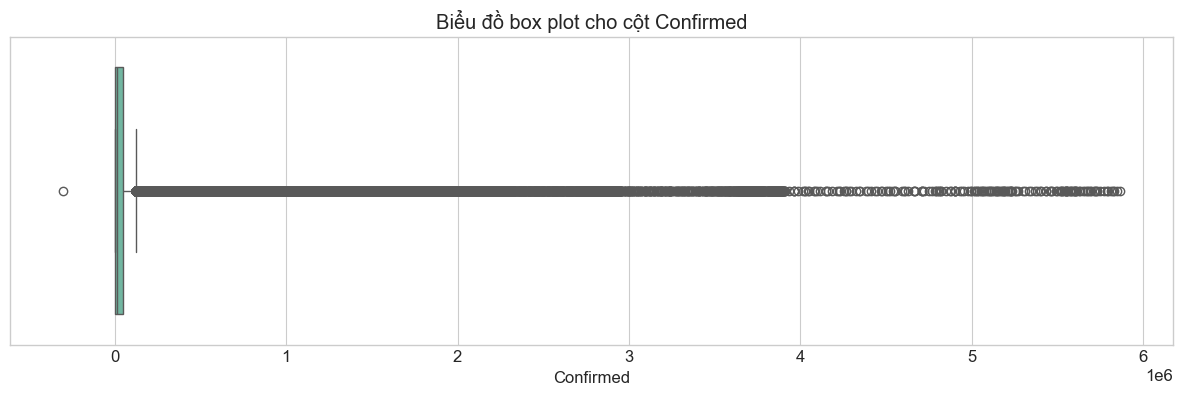

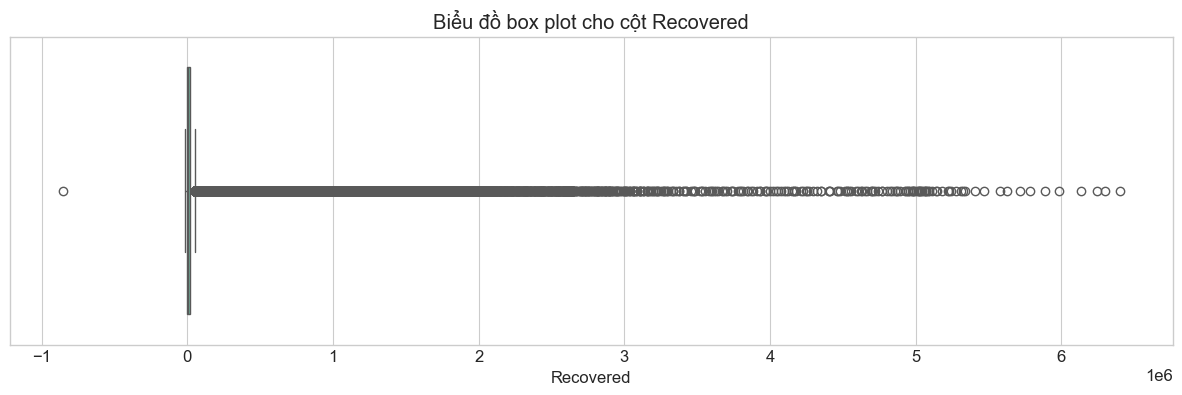

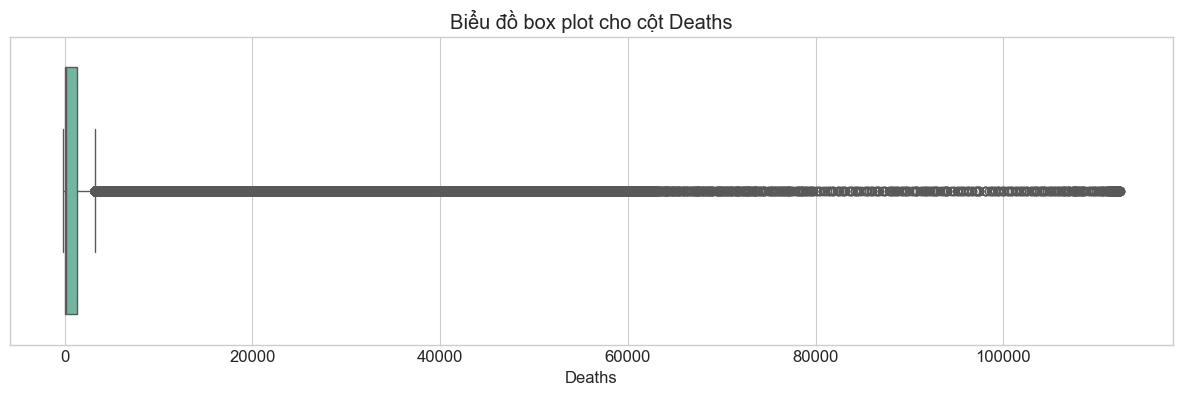

In [19]:
def visualize_outliers(data, columns):
    for column in columns:
        plt.figure(figsize=(15,4))
        sns.boxplot(x=data[column])
        plt.title(f'Biểu đồ box plot cho cột {column}')
        plt.show()

visualize_outliers(covid_data, numerical_cols)

**Phân tích chi tiết phân phối của outliers**

In [20]:
def analyze_outliers(data, columns):
    for column in columns:
        mean_val = data[column].mean()
        median_val = data[column].median()
        
        # Get top 5 highest values along with their observation dates and regions
        top_values = data[[column, 'ObservationDate', 'Country/Region']].nlargest(5, column)
        print(f"\nPhân tích {column}:")
        print(f"Giá trị trung bình: {mean_val:.2f}")
        print(f"Giá trị trung vị: {median_val:.2f}")
        print(f"\nTop 5 giá trị cao nhất và thông tin chi tiết:")
        print(top_values)


In [21]:

# Apply the function to the numerical columns
analyze_outliers(covid_data, numerical_cols)



Phân tích Confirmed:
Giá trị trung bình: 85670.91
Giá trị trung vị: 10375.00

Top 5 giá trị cao nhất và thông tin chi tiết:
        Confirmed ObservationDate Country/Region
298068    5863138      2021-05-19         France
297303    5845010      2021-05-18         France
296538    5829009      2021-05-17         France
295773    5825659      2021-05-16         France
295008    5811711      2021-05-15         France

Phân tích Recovered:
Giá trị trung bình: 50420.29
Giá trị trung vị: 1751.00

Top 5 giá trị cao nhất và thông tin chi tiết:
        Recovered ObservationDate Country/Region
179328    6399531      2020-12-14             US
178565    6298082      2020-12-13             US
177802    6246605      2020-12-12             US
177039    6135314      2020-11-12             US
176276    5985047      2020-10-12             US

Phân tích Deaths:
Giá trị trung bình: 2036.40
Giá trị trung vị: 192.00

Top 5 giá trị cao nhất và thông tin chi tiết:
        Deaths ObservationDate Country/Regio

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


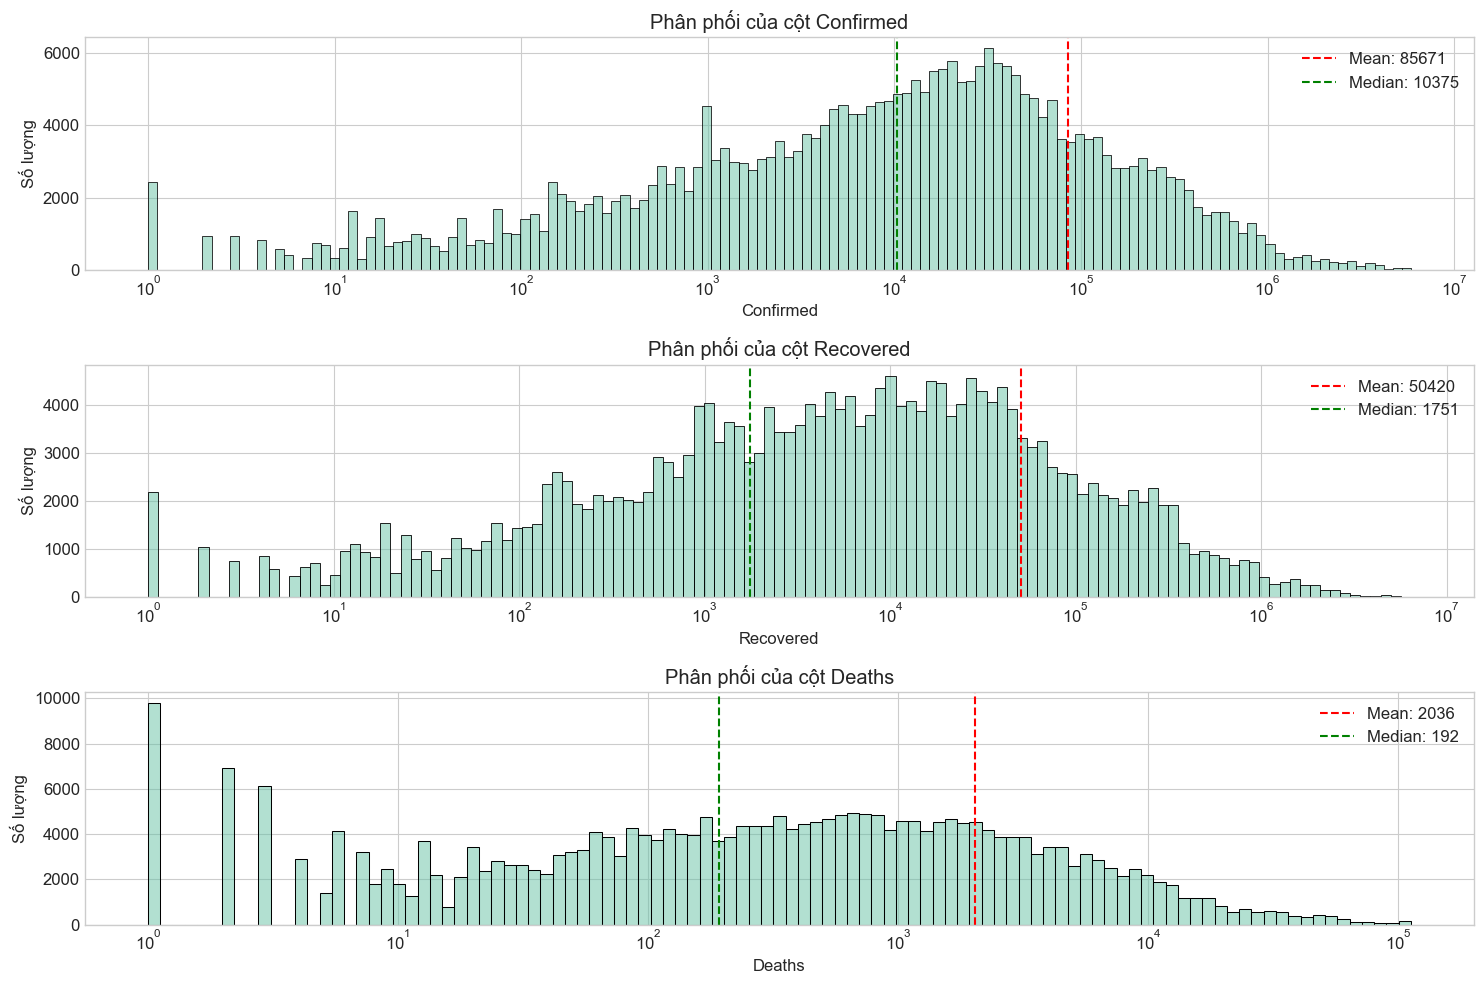

In [22]:
# Visualize the distribution of numerical columns
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_cols, 1):
    plt.subplot(3, 1, i)
    
    # log scale
    sns.histplot(data=covid_data, x=column, kde=True, log_scale=True)
    
    # Thêm thông tin thống kê
    mean_val = covid_data[column].mean()
    median_val = covid_data[column].median()
    plt.axvline(mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.0f}')
    plt.axvline(median_val, color='g', linestyle='--', label=f'Median: {median_val:.0f}')
    
    plt.title(f'Phân phối của cột {column}')
    plt.xlabel(f'{column}')
    plt.ylabel('Số lượng')
    plt.legend()

plt.tight_layout()
plt.show()


***Nhận xét:*** 
- Cả 3 biểu đồ đều có khá nhiều giá trị nằm trên tứ phân vị thứ ba, phản ánh các ngày có số ca mắc COVID-19, số lượng lớn người hồi phục, hoặc số ca tử vong tăng đột biến.

- Các giá trị outliers trong trường hợp này **không** phải là nhiễu mà là dữ liệu có ý nghĩa. Do đó **không** cần loại bỏ các giá trị này.

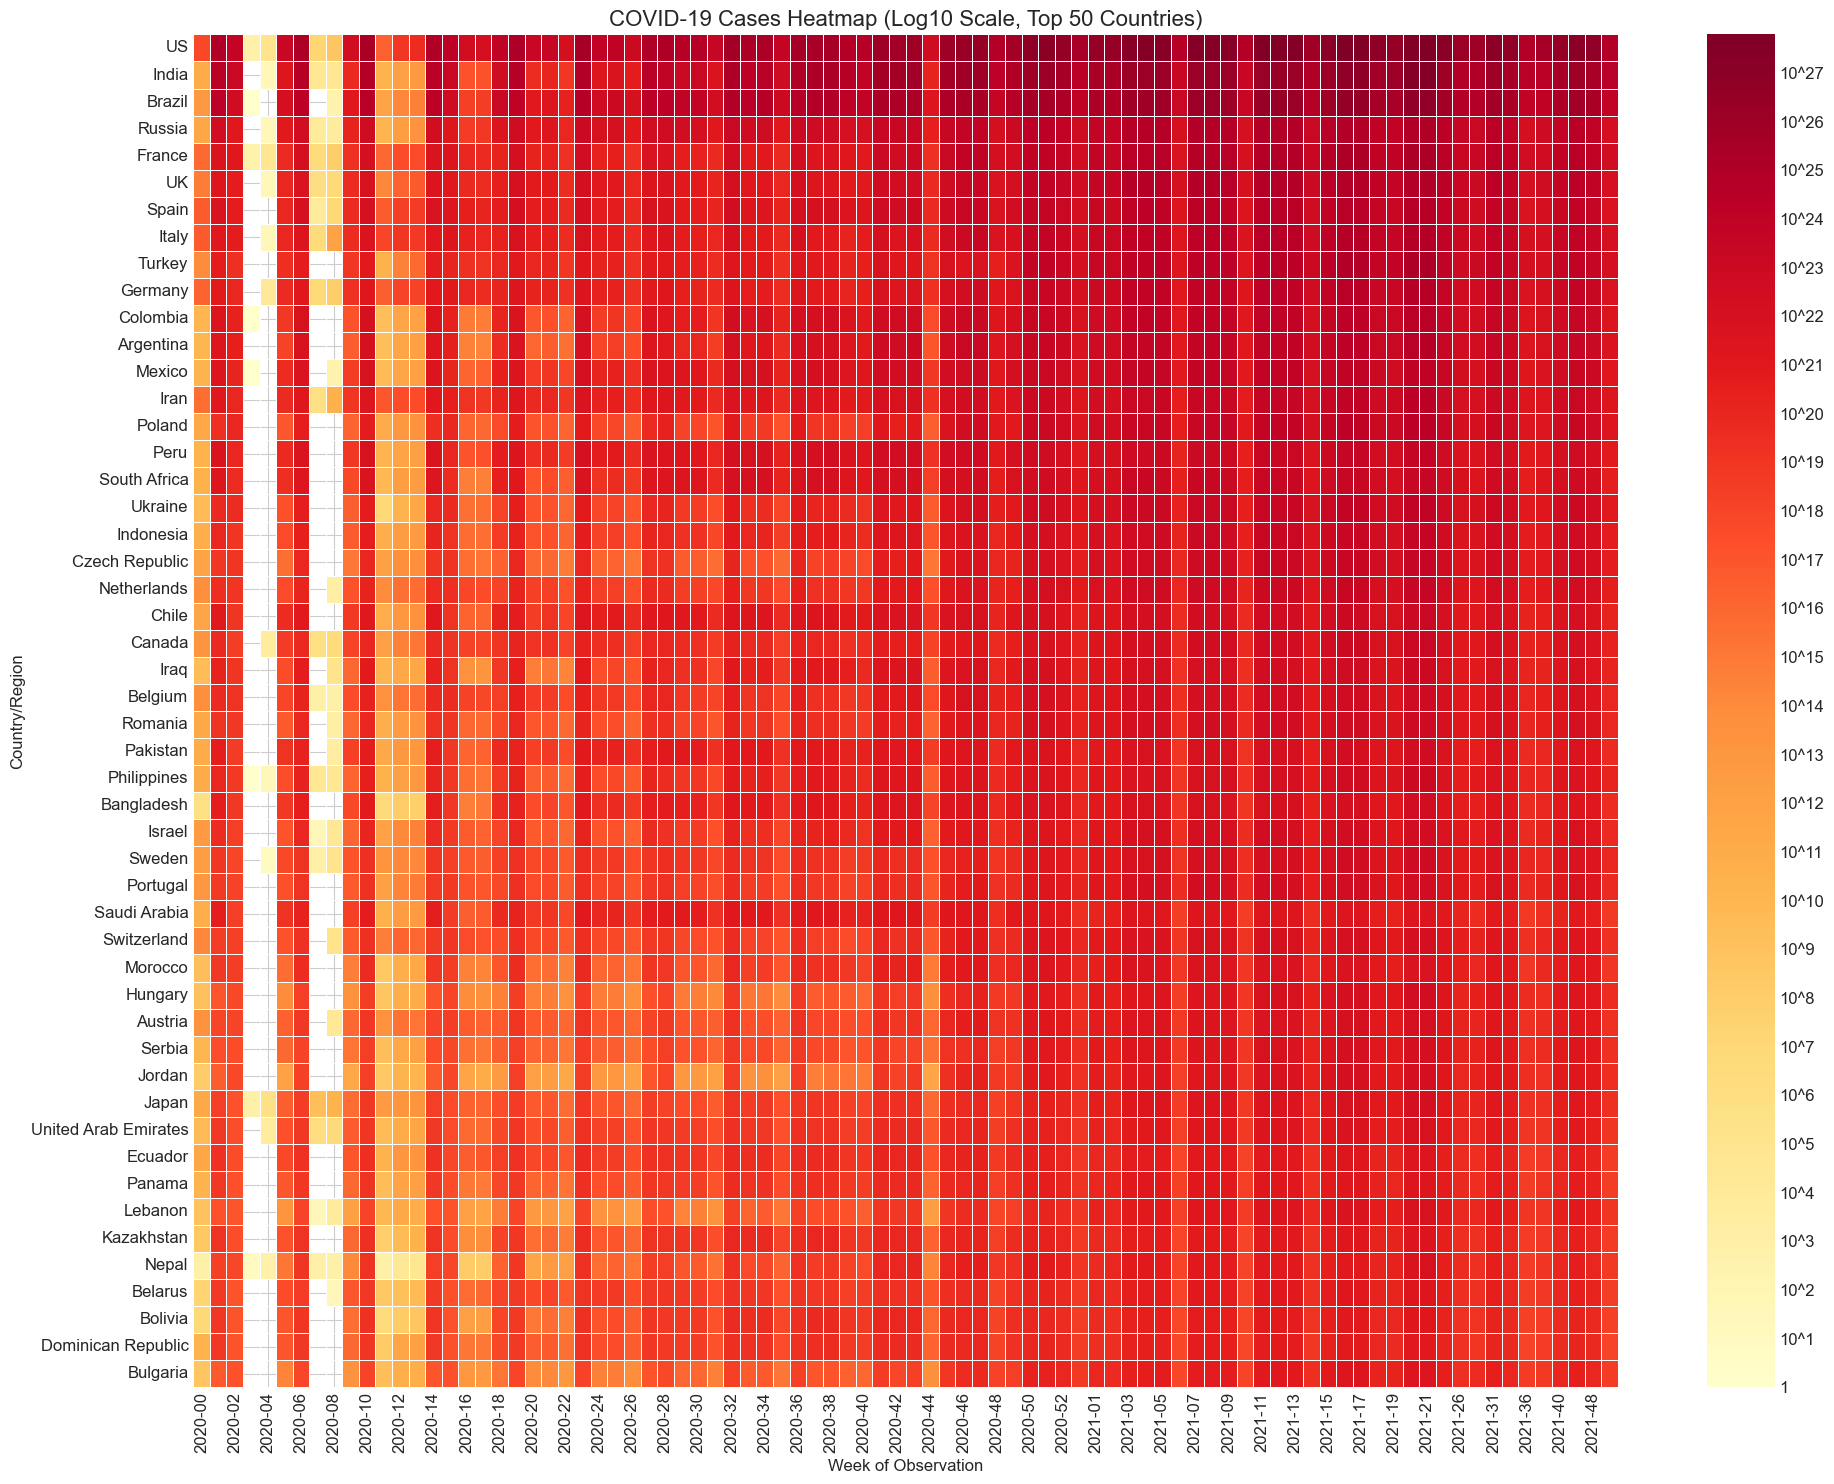

In [27]:
# Extract week number and year
covid_data['Week'] = covid_data['ObservationDate'].dt.strftime('%Y-%U')

# Group by country and week to get weekly cases
country_week = covid_data.groupby(['Country/Region', 'Week'])['Confirmed'].sum().unstack()

# Get top 50 countries by total cases
top_countries = covid_data.groupby('Country/Region')['Confirmed'].sum().sort_values(ascending=False).head(50).index
country_week = country_week.loc[top_countries]

# Apply log transformation (adding 1 to avoid log(0))
log_country_week = np.log2(country_week + 1)

# Create the heatmap with log scale
plt.figure(figsize=(20, 15))
ax = sns.heatmap(log_country_week, cmap='YlOrRd', linewidths=0.5, annot=False)

# Customize colorbar to show original values
cbar = ax.collections[0].colorbar
tick_locs = np.arange(0, np.log2(country_week.max().max() + 1))
cbar.set_ticks(tick_locs)
cbar.set_ticklabels([f"10^{int(x)}" if x >= 1 else f"{int(10**x)}" for x in tick_locs])

plt.title('COVID-19 Cases Heatmap (Log10 Scale, Top 50 Countries)', fontsize=16)
plt.xlabel('Week of Observation', fontsize=12)
plt.ylabel('Country/Region', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [28]:
country_stats = covid_data.groupby('Country/Region').agg(
    Total_Confirmed=('Confirmed', 'sum'),
    Total_Deaths=('Deaths', 'sum'),
    Total_Recovered=('Recovered', 'sum'),
    First_Case_Date=('ObservationDate', 'min'),
    Last_Case_Date=('ObservationDate', 'max')
).sort_values('Total_Confirmed', ascending=False)


# Thêm các cột tính toán
country_stats['Mortality_Rate'] = country_stats['Total_Deaths'] / country_stats['Total_Confirmed'] * 100
country_stats['Recovery_Rate'] = country_stats['Total_Recovered'] / country_stats['Total_Confirmed'] * 100
country_stats['Outbreak_Duration'] = (country_stats['Last_Case_Date'] - country_stats['First_Case_Date']).dt.days

# Lấy top 50 và hiển thị
top_50 = country_stats.head(50)
pd.set_option('display.max_rows', 50)
print(top_50[['Total_Confirmed', 'Total_Deaths', 'Total_Recovered', 
              'Mortality_Rate', 'Recovery_Rate', 'Outbreak_Duration']])

                      Total_Confirmed  Total_Deaths  Total_Recovered  \
Country/Region                                                         
US                         6049145667     123303762        503370956   
India                      3226768088      44424723       2900589824   
Brazil                     2653587540      72624610       2313677028   
Russia                      930548849      18363719        790705716   
France                      855188962      22720818         69407433   
UK                          783794384      29171984          2327572   
Spain                       649111763      19065104         61193618   
Italy                       636694305      26000702        487799849   
Turkey                      618940956       6841158        564170558   
Germany                     524166833      13364216        453383253   
Colombia                    515307146      13981703        468747010   
Argentina                   504802880      12112441        43875

In [32]:
covid_data[(covid_data['ObservationDate'] == '2021-05-29') & (covid_data['Country/Region'] == 'Russia')]['Confirmed'].sum()

np.int64(4995613)

In [16]:
df = covid_data.groupby("Country/Region").count()

In [17]:
df = df.reset_index()

In [18]:
df

,Country/Region,SNo,ObservationDate,Province/State,Last Update,Confirmed,Deaths,Recovered
0,Azerbaijan,1,1,1,1,1,1,1
1,"('St. Martin',)",1,1,1,1,1,1,1
2,Afghanistan,461,461,461,461,461,461,461
3,Albania,447,447,447,447,447,447,447
4,Algeria,460,460,460,460,460,460,460
...,...,...,...,...,...,...,...,...
224,West Bank and Gaza,430,430,430,430,430,430,430
225,Yemen,415,415,415,415,415,415,415
226,Zambia,438,438,438,438,438,438,438
227,Zimbabwe,436,436,436,436,436,436,436


In [19]:
print(df[df["Country/Region"]=="Azerbaijan"])

   Country/Region  SNo  ObservationDate  Province/State  Last Update  \
13     Azerbaijan  455              455             455          455   

    Confirmed  Deaths  Recovered  
13        455     455        455  


In [20]:
covid_data[covid_data["Country/Region"]=="Azerbaijan"].groupby("Country/Region").count()

,SNo,ObservationDate,Province/State,Last Update,Confirmed,Deaths,Recovered
Country/Region,,,,,,,
Azerbaijan,455,455,455,455,455,455,455


In [21]:
print(covid_data["Country/Region"].unique())


['Mainland China' 'Hong Kong' 'Macau' 'Taiwan' 'US' 'Japan' 'Thailand'
 'South Korea' 'China' 'Kiribati' 'Singapore' 'Philippines' 'Malaysia'
 'Vietnam' 'Australia' 'Mexico' 'Brazil' 'Colombia' 'France' 'Nepal'
 'Canada' 'Cambodia' 'Sri Lanka' 'Ivory Coast' 'Germany' 'Finland'
 'United Arab Emirates' 'India' 'Italy' 'UK' 'Russia' 'Sweden' 'Spain'
 'Belgium' 'Others' 'Egypt' 'Iran' 'Israel' 'Lebanon' 'Iraq' 'Oman'
 'Afghanistan' 'Bahrain' 'Kuwait' 'Austria' 'Algeria' 'Croatia'
 'Switzerland' 'Pakistan' 'Georgia' 'Greece' 'North Macedonia' 'Norway'
 'Romania' 'Denmark' 'Estonia' 'Netherlands' 'San Marino' ' Azerbaijan'
 'Belarus' 'Iceland' 'Lithuania' 'New Zealand' 'Nigeria' 'North Ireland'
 'Ireland' 'Luxembourg' 'Monaco' 'Qatar' 'Ecuador' 'Azerbaijan'
 'Czech Republic' 'Armenia' 'Dominican Republic' 'Indonesia' 'Portugal'
 'Andorra' 'Latvia' 'Morocco' 'Saudi Arabia' 'Senegal' 'Argentina' 'Chile'
 'Jordan' 'Ukraine' 'Saint Barthelemy' 'Hungary' 'Faroe Islands'
 'Gibraltar' 'Liechtenstei

In [22]:
#save cleaned data
covid_data.to_csv(os.path.join(PROCESSED_DATA_PATH, "covid_data_cleaned.csv"), index=False)
print("Data saved!")
print(covid_data.head(5))

Data saved!
   SNo ObservationDate Province/State  Country/Region         Last Update  \
0    1      2020-01-22          Anhui  Mainland China 2020-01-22 17:00:00   
1    2      2020-01-22        Beijing  Mainland China 2020-01-22 17:00:00   
2    3      2020-01-22      Chongqing  Mainland China 2020-01-22 17:00:00   
3    4      2020-01-22         Fujian  Mainland China 2020-01-22 17:00:00   
4    5      2020-01-22          Gansu  Mainland China 2020-01-22 17:00:00   

   Confirmed  Deaths  Recovered  
0          1       0          0  
1         14       0          0  
2          6       0          0  
3          1       0          0  
4          0       0          0  
